In [1]:
import pandas as pd
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import nltk as nltk
#import pyarrow
import bz2
import json
import datetime
from iteration_utilities import deepflatten
import nltk as nltk
import scipy.stats as stats
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
pd.options.mode.chained_assignment = None

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\asbjo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
df_2015 = pd.read_csv('media_outlet_with_sentiment/clean-quotes-2015_with_sentiment.csv.bz2', compression='bz2', index_col=[0])


C:\Users\asbjo\anaconda3\envs\ADA\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
df_2015['compound'] = pd.to_numeric(df_2015.compound, errors='coerce')

In [4]:
df_2015['compound'].dtype

dtype('float64')

In [5]:
files = ['media_outlet_with_sentiment/clean-quotes-2015_with_sentiment.csv.bz2',
    'media_outlet_with_sentiment/clean-quotes-2016_with_sentiment.csv.bz2',
    'media_outlet_with_sentiment/clean-quotes-2017_with_sentiment.csv.bz2',
    'media_outlet_with_sentiment/clean-quotes-2018_with_sentiment.csv.bz2',
    'media_outlet_with_sentiment/clean-quotes-2019_with_sentiment.csv.bz2',
    'media_outlet_with_sentiment/clean-quotes-2020_with_sentiment.csv.bz2']

In [6]:
df = pd.concat(map(pd.read_csv, [files[0], files[1],files[2], files[3], files[4], files[5]]))

C:\Users\asbjo\anaconda3\envs\ADA\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (2,3,4,5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
df['compound'] = pd.to_numeric(df.compound, errors='coerce')
df['positive'] = pd.to_numeric(df.positive, errors='coerce')
df['negative'] = pd.to_numeric(df.negative, errors='coerce')
df['blob_polar'] = pd.to_numeric(df.blob_polar, errors='coerce')
df['blob_subj'] = pd.to_numeric(df.blob_subj, errors='coerce')

df = df.drop(axis=1, columns = 'Unnamed: 0')

In [8]:
df.describe()

,compound,positive,negative,blob_polar,blob_subj
count,1.191700e+07,1.191700e+07,1.191700e+07,1.191700e+07,1.191700e+07
mean,1.522685e-01,1.239034e-01,6.751057e-02,1.070985e-01,3.821861e-01
std,4.606570e-01,1.416592e-01,1.135490e-01,2.694825e-01,3.010360e-01
min,-9.991000e-01,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00
25%,-2.580000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,9.000000e-02,0.000000e+00,0.000000e+00,4.000000e-01
75%,5.267000e-01,2.070000e-01,1.070000e-01,2.500000e-01,6.000000e-01
max,9.996000e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [9]:
df.head()

,media_outlet,compound,positive,negative,blob_polar,blob_subj,date_short
0,washingtonpost,0.2500,0.083,0.000,0.000000,0.000000,2015-12-13
1,startribune,0.0000,0.000,0.000,0.062500,0.354167,2015-10-02
2,mtv,0.0000,0.000,0.000,-0.083333,0.216667,2015-10-09
3,express,-0.3400,0.073,0.094,0.600000,1.000000,2015-11-17
4,reuters,-0.2732,0.000,0.110,-0.187500,0.500000,2015-02-06


In [10]:
df = df[df.media_outlet != 'media_outlet']
df = df[df.media_outlet != 'starmagazine']

In [11]:
df.dtypes

media_outlet     object
compound        float64
positive        float64
negative        float64
blob_polar      float64
blob_subj       float64
date_short       object
dtype: object

In [12]:
media = df.groupby(by='media_outlet').count()




In [13]:
media

,compound,positive,negative,blob_polar,blob_subj,date_short
media_outlet,,,,,,
aarp,10647,10647,10647,10647,10647,10647
bbc,633483,633483,633483,633483,633483,633483
chicagotribune,302545,302545,302545,302545,302545,302545
cnn,542743,542743,542743,542743,542743,542743
dailymail,104839,104839,104839,104839,104839,104839
economist,30048,30048,30048,30048,30048,30048
espn,889974,889974,889974,889974,889974,889974
express,1219309,1219309,1219309,1219309,1219309,1219309
foxnews,448658,448658,448658,448658,448658,448658


In [41]:
print(df.groupby(by = 'media_outlet').mean())

                    compound  positive  negative  blob_polar  blob_subj
media_outlet                                                           
aarp                0.183836  0.131132  0.060667    0.126072   0.374449
bbc                 0.153965  0.125621  0.067830    0.109402   0.382687
chicagotribune      0.185827  0.130868  0.056026    0.124636   0.375464
cnn                 0.095295  0.110996  0.075607    0.088059   0.367360
dailymail           0.187443  0.133669  0.061801    0.114771   0.378852
economist           0.102192  0.106390  0.072124    0.089859   0.373278
espn                0.278250  0.145377  0.049500    0.147783   0.404517
express             0.163235  0.121867  0.064466    0.106405   0.388064
foxnews             0.076495  0.112459  0.084968    0.080844   0.371784
independent         0.161623  0.124508  0.067617    0.108429   0.389633
intouchweekly       0.165652  0.142469  0.073848    0.123912   0.415321
latimes             0.153323  0.123426  0.063203    0.109983   0

In [14]:
nytimes = df.loc[df['media_outlet']=='nytimes']
wsj = df.loc[df['media_outlet']=='wsj']
people = df.loc[df['media_outlet']=='people']
womansday = df.loc[df['media_outlet'] == 'womansday'] 
mtv = df.loc[df['media_outlet'] == 'mtv']
tmz = df.loc[df['media_outlet'] == 'tmz']
espn = df.loc[df['media_outlet'] == 'espn']

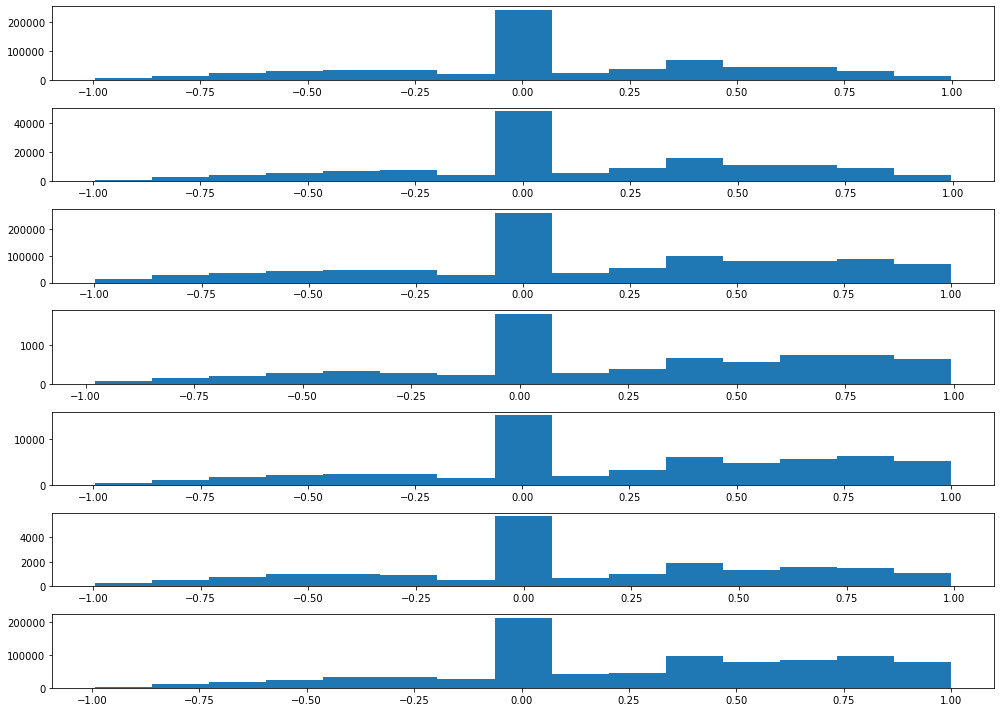

In [15]:
fig, ax = plt.subplots(7,1, figsize=(14,10))

ax[0].hist(nytimes.compound, bins=15)

ax[1].hist(wsj.compound, bins=15)

ax[2].hist(people.compound, bins = 15)

ax[3].hist(womansday.compound, bins = 15)

ax[4].hist(mtv.compound, bins = 15)

ax[5].hist(tmz.compound, bins = 15)

ax[6].hist(espn.compound, bins = 15)

fig.tight_layout()

plt.show()

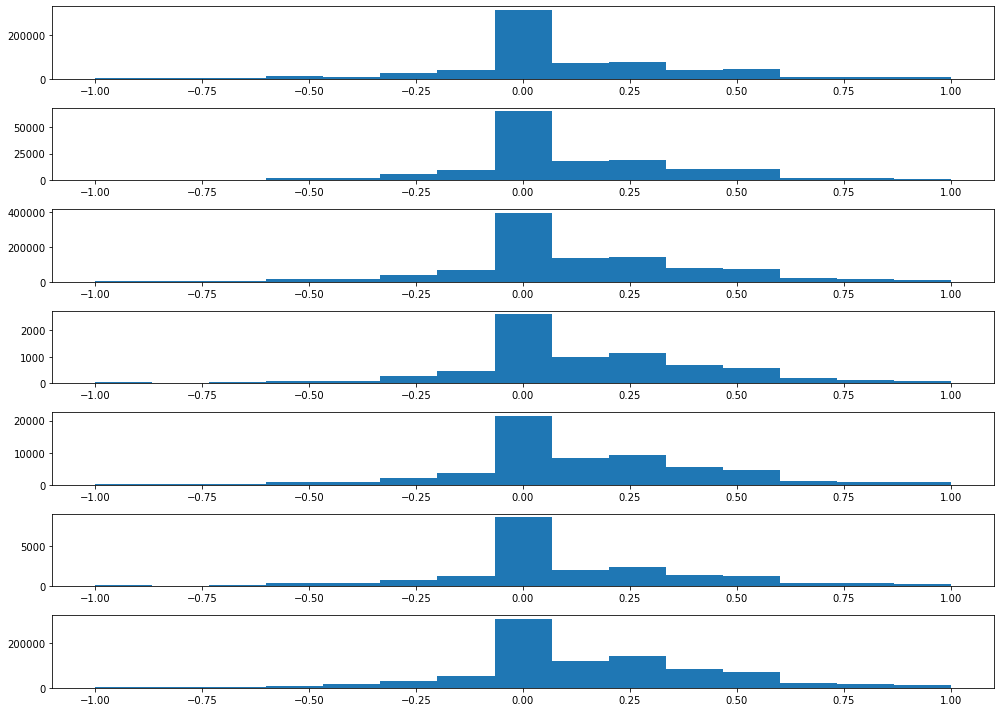

In [16]:
fig, ax = plt.subplots(7,1, figsize=(14,10))

ax[0].hist(nytimes.blob_polar, bins=15)

ax[1].hist(wsj.blob_polar, bins=15)

ax[2].hist(people.blob_polar, bins = 15)

ax[3].hist(womansday.blob_polar, bins = 15)

ax[4].hist(mtv.blob_polar, bins = 15)

ax[5].hist(tmz.blob_polar, bins = 15)

ax[6].hist(espn.blob_polar, bins = 15)

fig.tight_layout()

plt.show()

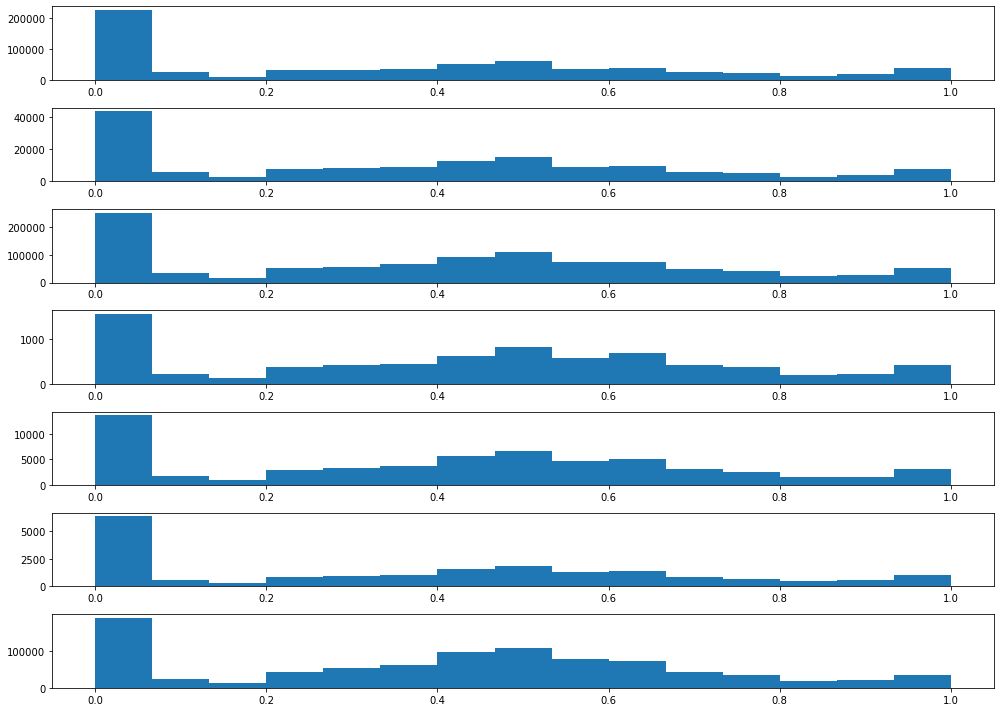

In [17]:
fig, ax = plt.subplots(7,1, figsize=(14,10))

ax[0].hist(nytimes.blob_subj, bins=15)

ax[1].hist(wsj.blob_subj, bins=15)

ax[2].hist(people.blob_subj, bins = 15)

ax[3].hist(womansday.blob_subj, bins = 15)

ax[4].hist(mtv.blob_subj, bins = 15)

ax[5].hist(tmz.blob_subj, bins = 15)

ax[6].hist(espn.blob_subj, bins = 15)

fig.tight_layout()

plt.show()

In [20]:
print(nytimes.compound.mean())
print(womansday.compound.mean())

0.08528024693197732
0.22793258081752665


In [21]:
media_outlets = ['nytimes', 'wsj', 'womansday', 'nbcnews', 'foxnews', 'aarp', 'usmagazine', 'espn', 'usatoday', 
'newstoday', 'sportingnews', 'theguardian', 'people', 'tmz', 'mtv', 'cnn', 'msn', 'reuters', 'timesrepublican', 
'nationalgeographic', 'latimes', 'washingtonpost', 'startribune', 'chicagotribune', 'usnews', 'theathletic', 
'rollingstone', 'vanityfair', 'intouchweekly', 'starmagazine', 'bbc', 'independent', 'thesun', 'thetimes',
'express', 'dailymail', 'mirror', 'economist']

newspapers = ['nytimes', 'wsj','foxnews', 'aarp','usatoday', 'newstoday', 'reuters', 'timesrepublican', 
'latimes', 'washingtonpost', 'startribune', 'cnn',  'chicagotribune', 'usnews', 'nbcnews', 'theguardian',
'bbc', 'independent', 'thesun', 'thetimes','express', 'dailymail', 'mirror', 'economist']

celebmagazines = ['womansday', 'usmagazine', 'people','tmz', 'intouchweekly', 'starmagazine']

other = ['mtv', 'msn','nationalgeographic', 'vanityfair', 'rollingstone']

sport = ['espn', 'sportingnews', 'theathletic']


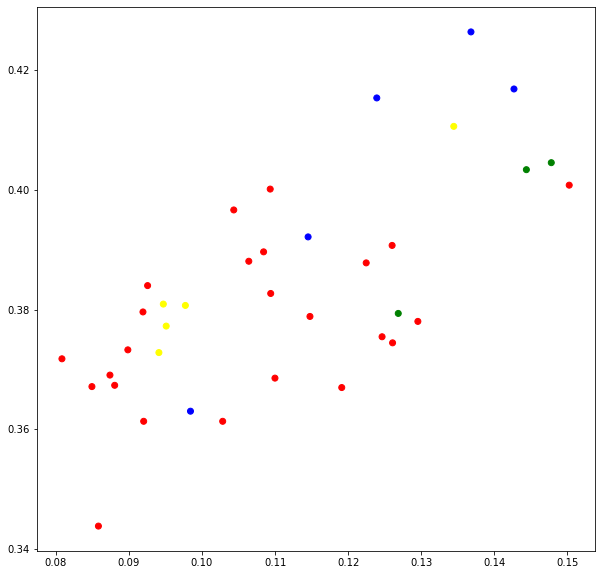

In [22]:
mean_polar = df.groupby(by = ['media_outlet'])['blob_polar'].mean()
mean_subj = df.groupby(by = ['media_outlet'])['blob_subj'].mean()


name = mean_polar.keys()

def pltcolor(lst):
    cols=[]
    for l in lst:
        if (l in newspapers):
            cols.append('red')
        elif (l in celebmagazines):
            cols.append('blue')
        elif (l in other):
            cols.append('yellow')
        else:
            cols.append('green')
    return cols
# Create the colors list using the function above
cols=pltcolor(mean_polar.keys())

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(mean_polar, mean_subj, c=cols)
for i, txt in enumerate(name):
    ax.annotate(txt, (mean_subj[i], mean_polar[i]))


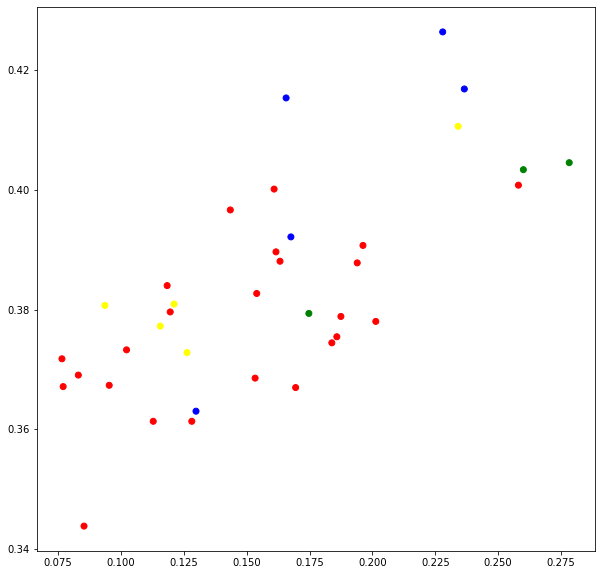

In [38]:
mean_polar = df.groupby(by = ['media_outlet'])['compound'].mean()
mean_subj = df.groupby(by = ['media_outlet'])['blob_subj'].mean()


name = mean_polar.keys()

def pltcolor(lst):
    cols=[]
    for l in lst:
        if (l in newspapers):
            cols.append('red')
        elif (l in celebmagazines):
            cols.append('blue')
        elif (l in other):
            cols.append('yellow')
        else:
            cols.append('green')
    return cols
# Create the colors list using the function above
cols=pltcolor(mean_polar.keys())

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(mean_polar, mean_subj, c=cols)
for i, txt in enumerate(name):
    ax.annotate(txt, (mean_subj[i], mean_polar[i]))

In [23]:
a  = mean_polar.keys()
a

Index(['aarp', 'bbc', 'chicagotribune', 'cnn', 'dailymail', 'economist',
       'espn', 'express', 'foxnews', 'independent', 'intouchweekly', 'latimes',
       'mirror', 'msn', 'mtv', 'nationalgeographic', 'nbcnews', 'newstoday',
       'nytimes', 'people', 'reuters', 'rollingstone', 'sportingnews',
       'startribune', 'theathletic', 'theguardian', 'thesun', 'thetimes',
       'timesrepublican', 'tmz', 'usatoday', 'usmagazine', 'usnews',
       'vanityfair', 'washingtonpost', 'womansday', 'wsj'],
      dtype='object', name='media_outlet')

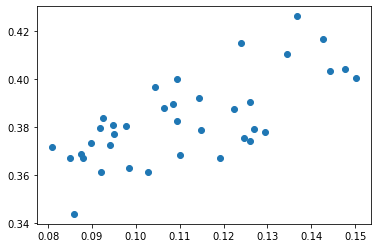

In [24]:
plt.scatter(mean_polar, mean_subj)

In [25]:
date = nytimes.groupby('date_short').positive.mean()

In [26]:
from datetime import datetime

def weekday_number(date):
  ''' Returning the weekday number of a date, e.g., 0 for Mondays.

  Parameters
  ----------
  date: datetime
    A datetime for which to find the weekday number.

  Returns
  -------
  weekday_number: int
    The weekday number of the date.
  '''

  weekday_number = date.weekday()
  return weekday_number


def weekday(date):
  ''' Returning the name of the weekday for a date.

  Parameters
  ----------
  date: datetime
    A datetime for which to find the weekday.

  Returns
  -------
  weekday: str
    The weekday of the date.
  '''
  
  day_number = date.weekday()
  week_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
  weekday = week_days[day_number]
  return weekday


def week(date):
  ''' Returning the week number of a date.

  Parameters
  ----------
  date: datetime
    A datetime for which to find the weekday.

  Returns
  -------
  week_number: int
    The week number of the date.
  '''

  week_number = date.week()
  return week_number


def month(date):
  ''' Returning the month name of date.

  Parameters
  ----------
  date: datetime
    A date for which to find the month name.

  Returns
  -------
  name_month: str
    The name of the month.
  '''

  name_month = date.month_name()
  return name_month


def add_time(chunk):
  ''' Adding columns for weekday, weekday number and month name to a chunk.

  Parameters
  ----------
  chunk: dataframe
    The chunk for which to add date information.

  Returns
  -------
  chunk: dataframe
    The chunk with date information.
  '''

  chunk['date_short'] = chunk['date_short'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
  chunk['weekday_number'] = chunk['date_short'].apply(lambda x: weekday_number(x))  
  chunk['Month'] =  chunk['date_short'].apply(lambda x: month(x))
  return chunk

In [27]:
nytimes = add_time(nytimes)

In [28]:
nytimes.head()

,media_outlet,compound,positive,negative,blob_polar,blob_subj,date_short,weekday_number,Month
356,nytimes,-0.3612,0.000,0.294,0.0,0.0,2015-12-14,0,December
536,nytimes,0.1531,0.233,0.183,0.0,0.0,2015-10-02,4,October
627,nytimes,-0.6249,0.165,0.615,-0.9,0.7,2015-01-29,3,January
1239,nytimes,0.0000,0.000,0.000,0.2,0.4,2015-11-30,0,November
1434,nytimes,0.3612,0.455,0.000,0.0,0.0,2015-07-31,4,July


In [29]:
t, p = stats.ttest_ind(nytimes['compound'], wsj['compound'], equal_var=False)
print("Two sided paired t-test with null hypothesis: The mean mood in NYtimes equals the mean mood in Wall Street Journal:")
print(f"t-value: {t}, p-value: {p}")

Two sided paired t-test with null hypothesis: The mean mood in NYtimes equals the mean mood in Wall Street Journal:
t-value: -35.834473757551145, p-value: 2.1812370930100076e-280


In [30]:
day = nytimes.groupby('weekday_number').compound.mean()
month = nytimes.groupby('Month').compound.mean().reset_index()

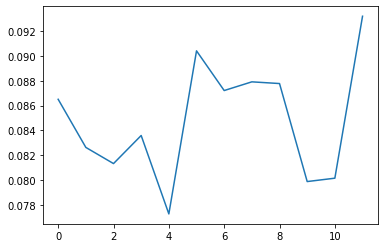

In [31]:
plt.plot(month['compound'])


In [32]:
date = nytimes.groupby('date_short').positive.mean().reset_index()

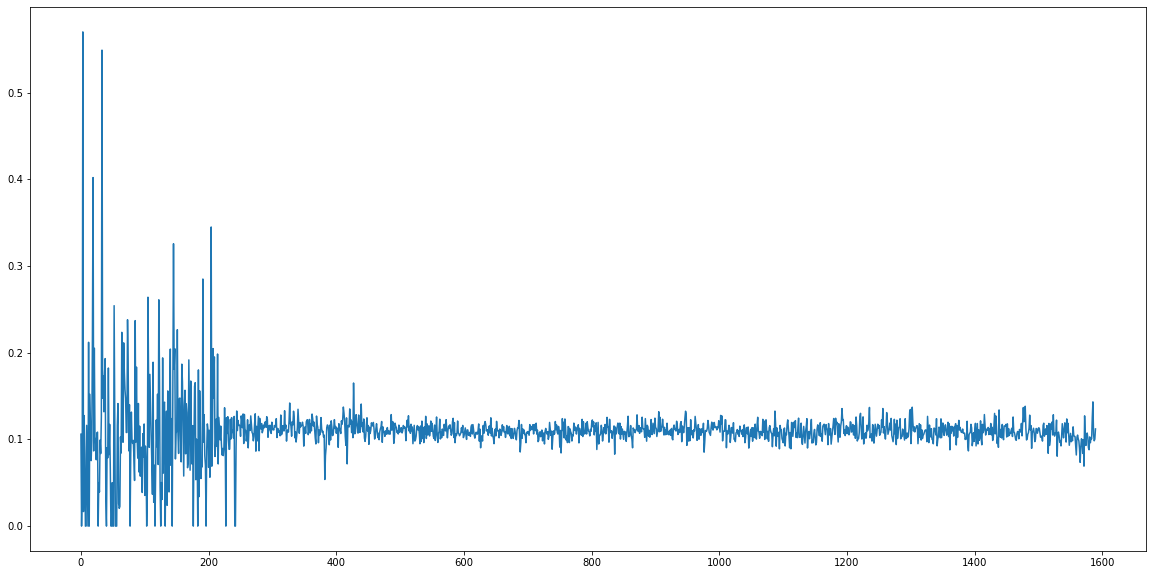

In [33]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(date['positive'])

C:\Users\asbjo\anaconda3\envs\ADA\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='blob_subj', ylabel='blob_polar'>

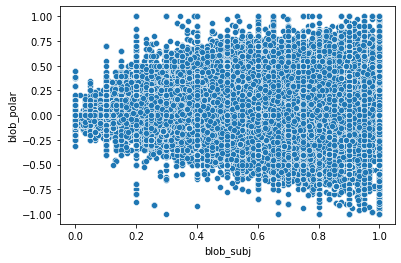

In [34]:
sns.scatterplot(nytimes['blob_subj'] , nytimes['blob_polar'])